# Exploration of new energy-dependent USU functionality

In this notebook, we study the impact of the inclusion of energy-dependent USU uncertainties on the evaluation. The Bayesian update formula is the starting point,
$$ \rho(\vec{\sigma} \,|\, \vec{m}, \Sigma) \propto \rho(\vec{m} \,|\, \mathcal{M}, \vec{\sigma}, \Sigma) \times \rho(\vec{\sigma})$$
with $\vec{\sigma}$ the true cross sections that shall be determined, $\vec{m}$ the measured values and $\vec{\Sigma}$ the experimental covariance matrix. The model $\mathcal{M}$ is responsible for mapping the cross sections given on the energy grid of $\vec{\sigma}$ to the energies of the measured values given in $\vec{m}$. If $\mathcal{M}$ is linear and the distributions on the right-hand side multivariate normal, also the posterior distribution (left-hand side) is multivariate normal whose center vector and covariance matrix can be obtained by the GLS equations.

For the consideration of energy-dependent USU, we introduce the following additional assumptions: Each dataset is associated with USU **errors** at a pre-defined energy mesh (e.g. 1, 2, 3, 4 MeV below). These USU errors can not be measured and are unknown, therefore they are associated with an USU **uncertainty**. So for each energy $E_i$, each dataset has an USU **error** $\varepsilon_i$. All USU errors at the same incident energy are associated with the same USU uncertainty $u_i$. We assume that the USU error at intermediate energies is given by linear interpolation of the USU errors at the enclosing energy points. Performing marginalization (integrating over the USU errors), yields a model where only the USU uncertainties remain, which are effectively parameters in the covariance matrix. The above statistical model therefore is modified in the following way:
$$ \rho(\vec{\sigma}, \Sigma(\vec{u}) \,|\, \vec{m}) \propto \rho(\vec{m} \,|\, \mathcal{M}, \vec{\sigma}, \Sigma(\vec{u})) \times \rho(\vec{\sigma}) \times \rho(\vec{u})$$
As can be seen, an additional prior distribution is imposed on the USU uncertainties. The experimental covariance matrix is given by the covariance matrix from the GMA database file augmented with contributions from the energy-dependent USU uncertainties. With this augmented specification, there is no longer an analytic formula to calculate moments of the posterior distribution and we need to resort to Monte Carlo sampling. The Hamilton Monte Carlo is an efficient algorithm that is able to create samples from the posterior distribution.

In the following, the results are presented for the simple toy scenario. The code to produce plots and results can be ignored. Text is provided in-between plots to explain the meaning of plots and results.

## Loading required packages and result files

Essential Python packages for visualiztion are loaded. In addition we prepare some quantities here, such as covariance matrices. The presentation of results start in the next section.

In [116]:
import sys
sys.path.append('../../..')
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from gmapy.data_management.object_utils import (
    load_objects, save_objects
)
import seaborn as sns
import tensorflow as tf

In [44]:
chain_relcov_usu, = load_objects('output/03_mcmc_sampling_output.pkl', 'chain')
priortable, exptable, usu_df, expcov, compmap = load_objects('output/01_model_preparation_output.pkl',
    'priortable', 'exptable', 'usu_df', 'expcov', 'compmap')
# load the experimental covariance matrices
like_cov_fun_rel_usu, = load_objects('output/01_model_preparation_output.pkl', 'like_cov_fun')
expcov_rel_nousu, = load_objects('../example-002/output/01_model_preparation_output.pkl', 'expcov_linop')
expcov_abs_nousu, = load_objects('../example-003/output/01_model_preparation_output.pkl', 'expcov_linop')
# for comparison, without usu and relative
chain_relcov_nousu, = load_objects('../example-002/output/03_mcmc_sampling_output.pkl', 'chain')
chain_abscov_nousu, = load_objects('../example-003/output/03_mcmc_sampling_output.pkl', 'chain')

In [3]:
# prepare absolute covmat
expvals = exptable.DATA.to_numpy()
absexpcov = expcov.toarray() * expvals.reshape((-1, 1)) * expvals.reshape((1, -1))
absexpuncs = np.sqrt(absexpcov.diagonal())
exptable['UNC'] = absexpuncs

## Original experimental data

First we plot the expeirmental data along with their uncertainties to obtain a visual impression of the degree of inconsistency.

Text(0, 0.5, 'cross section')

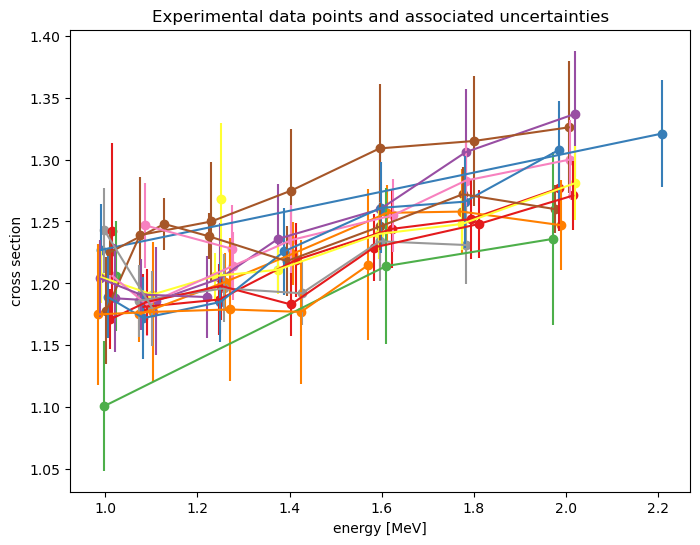

In [4]:
num_groups = len(exptable['NODE'].unique())
color_palette = sns.color_palette("Set1", n_colors=num_groups)
jittered_x = exptable['ENERGY'] + np.random.uniform(-0.03, 0.03, len(exptable))
exptable['jitx'] = jittered_x
plt.figure(figsize=(8,6))
sns.scatterplot(x='jitx', y='DATA', hue='NODE', data=exptable, legend=False)
for i, (group, group_data) in enumerate(exptable.groupby('NODE')):
    color = color_palette[i]
    plt.scatter(group_data['jitx'], group_data['DATA'], color=color)
    plt.errorbar(group_data['jitx'], group_data['DATA'], yerr=group_data['UNC'], color=color)
plt.title('Experimental data points and associated uncertainties')
plt.xlabel('energy [MeV]')
plt.ylabel('cross section')

## Determination of USU uncertainties

As mentioned above, USU uncertainties are given on a pre-defined energy mesh (1, 2, 3, 4 MeV). They characterize much USU errors are expected to scatter. The following plots show the posterior distribution of the USU uncertainty at the respective energy points. As all the experimental data is between 1 and 2 MeV, the posterior of the USU uncertainty at 1 and 2 MeV are peaked with the maximum of the distribution being at about 2\%. In contrast, no experimental data points are at 3 MeV and 4 MeV, so there is no experimental information there to inform USU uncertainties. Therefore, the distributions are very uninformative, hence samples of the USU uncertainty span many orders of magnitude. 

Text(0.5, 1.0, 'Posterior of USU uncertainty at 4 MeV')

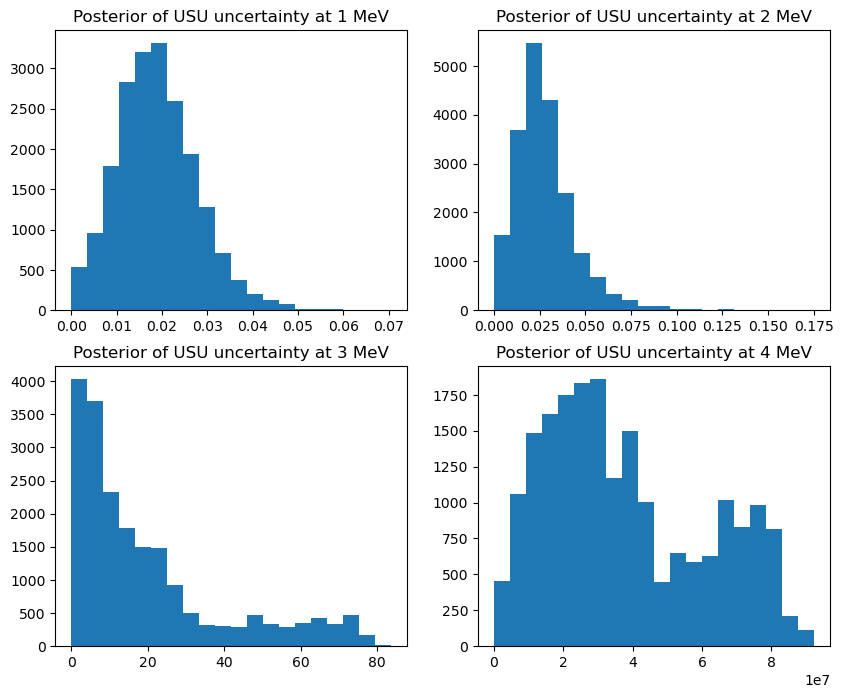

In [6]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
axes[0, 0].hist(np.abs(chain_relcov_usu[:,8]), bins=20)
axes[0, 0].set_title('Posterior of USU uncertainty at 1 MeV')
axes[0, 1].hist(np.abs(chain_relcov_usu[:,9]), bins=20)
axes[0, 1].set_title('Posterior of USU uncertainty at 2 MeV')
axes[1, 0].hist(np.abs(chain_relcov_usu[:,10]), bins=20)
axes[1, 0].set_title('Posterior of USU uncertainty at 3 MeV')
axes[1, 1].hist(np.abs(chain_relcov_usu[:,11]), bins=20)
axes[1, 1].set_title('Posterior of USU uncertainty at 4 MeV')

## Impact of USU uncertainties on the evaluation mean values

USU uncertainties are inferred at the same time as the true cross sections. In the following we compare how an evaluation with the consideration of USU uncertainties is different from one without. We have studied three cases:

- blue: we use a relative experimental covariance matirx (~PPP correction) and take into account USU
- green: we use a relative experimental covariance matrix (~PPP correction) without USU
- red: we use an absolute experimental covariance matrix without USU

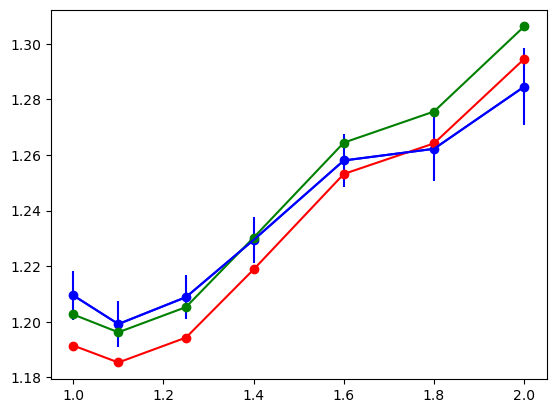

In [92]:
energies = priortable['ENERGY'].to_numpy()[:-1]
postvals_relcov_usu = np.mean(chain_relcov_usu[:,:-5], axis=0)
postuncs_relcov_usu = np.std(chain_relcov_usu[:,:-5], axis=0)
plt.plot(energies, postvals, marker='o', color='blue')
plt.errorbar(energies, postvals, postuncs, color='blue')
# for comparison without USU but with relative experimental covmat
postvals_relcov_nousu = np.mean(chain_relcov_nousu[:,:-1], axis=0)
postuncs_relcov_nousu = np.std(chain_relcov_nousu[:,:-1], axis=0)
plt.plot(energies, postvals_relcov_nousu, marker='o', color='green')
# for comparison without USU and with absolute experimental covmat
postvals_abscov_nousu = np.mean(chain_abscov_nousu[:,:-1], axis=0)
postuncs_abscov_nousu = np.std(chain_abscov_nousu[:,:-1], axis=0)
plt.plot(energies, postvals_abscov_nousu, marker='o', color='red')

## Impact of USU consideration on evaluated uncertainties

Here we study how the consideration of USU changes the evaluated uncertainties. Same color code as before. The additional uncertainty due to the consideration of USU significantly expands the evaluated uncertainties.

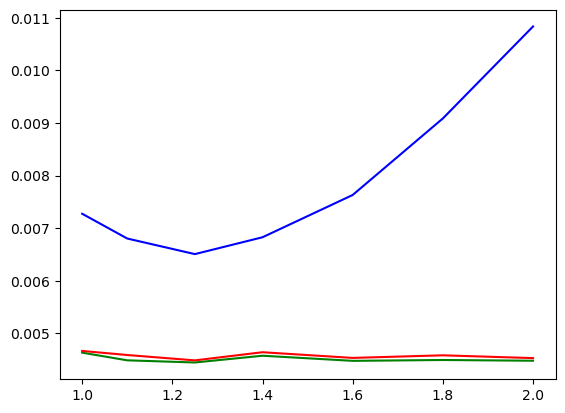

In [11]:
# comparison of posterior uncertainties
plt.plot(energies, postuncs_relcov_usu / postvals_relcov_usu, color='blue')
plt.plot(energies, postuncs_relcov_nousu / postvals_relcov_nousu, color='green')
plt.plot(energies, postuncs_abscov_nousu / postvals_abscov_nousu, color='red')

## Chisquare value comparison

For each scenario, we take the evaluated values and compute the chisquare per df using the experimental covariance matrix. In the case where USU is considered, the experimental covariance matrix is constructed using the posterior mean values of the USU uncertainties.

In [118]:
def chisquare(postvals, covop_linop):
    propvals = compmap(postvals).numpy()
    d = np.reshape(propvals - exptable['DATA'].to_numpy(), (-1, 1))
    chisqr = d.T @ covop_linop.solve(d).numpy() / len(exptable)
    return np.squeeze(chisqr)

def rel2abs_covop(postvals, covop_linop):
    propvals = compmap(postvals).numpy()
    scale_op = tf.linalg.LinearOperatorDiag(propvals)
    return tf.linalg.LinearOperatorComposition([scale_op, covop_linop, scale_op.adjoint()])

In [119]:
postvals_relcov_usu = np.mean(chain_relcov_usu[:,:-4], axis=0)
postvals_abscov_nousu = np.mean(chain_abscov_nousu[:,:], axis=0)
postvals_relcov_nousu = np.mean(chain_relcov_nousu[:,:], axis=0)

tmp = rel2abs_covop(postvals_relcov_usu, like_cov_fun_rel_usu(post_usu_pars))
chisquare_relcov_usu = chisquare(postvals_relcov_usu, tmp)
tmp = rel2abs_covop(postvals_relcov_nousu, expcov_rel_nousu)
chisquare_relcov_nousu = chisquare(postvals_relcov_nousu, tmp)
chisquare_abscov_nousu = chisquare(postvals_abscov_nousu, expcov_abs_nousu)
print(f'chisquare with USU augmented experiments: {chisquare_relcov_usu}')
print(f'chisquare with relative experimental covmat: {chisquare_relcov_nousu}')
print(f'chisquare with relative experimental covmat: {chisquare_abscov_nousu}')

chisquare with USU augmented experiments: 1.931072464902608
chisquare with relative experimental covmat: 3.2191175314384157
chisquare with relative experimental covmat: 3.185502881605799
